In [1]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from attention import *

In [2]:
import pickle

In [3]:
# Open the file in binary mode
with open('y_tr_custom_attention.pkl', 'rb') as file:
    # Call load method to deserialze
    y_tr = pickle.load(file)
with open('x_tr_custom_attention.pkl', 'rb') as file:
    # Call load method to deserialze
    x_tr = pickle.load(file)
with open('y_val_custom_attention.pkl', 'rb') as file:
    # Call load method to deserialze
    y_val = pickle.load(file)
with open('x_val_custom_attention.pkl', 'rb') as file:
    # Call load method to deserialze
    x_val = pickle.load(file)

In [4]:
y_tr.shape,  x_tr.shape, x_val.shape, y_val.shape,

((902, 8), (902, 30), (97, 30), (97, 8))

In [5]:
max_text_len=30
max_summary_len=8
x_voc = 936 # Number of unique words in the input data (x_tr)
y_voc = 103 # Number of unique words in the output data (y_tr)

In [6]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

In [7]:
#embedding layer
enc_emb =  Embedding(input_dim = x_voc, output_dim = embedding_dim, input_length=30,trainable=True)(encoder_inputs)

In [8]:
enc_emb

<KerasTensor: shape=(None, 30, 100) dtype=float32 (created by layer 'embedding')>

In [9]:
#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

In [10]:
encoder_output1, state_h1, state_c1

(<KerasTensor: shape=(None, 30, 300) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm')>)

In [11]:
#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

In [12]:
encoder_output2, state_h2, state_c2 

(<KerasTensor: shape=(None, 30, 300) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm_1')>)

In [13]:
#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [14]:
encoder_outputs, state_h, state_c

(<KerasTensor: shape=(None, 30, 300) dtype=float32 (created by layer 'lstm_2')>,
 <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm_2')>,
 <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm_2')>)

In [15]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
decoder_inputs

<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'input_2')>

In [16]:
#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
dec_emb

<KerasTensor: shape=(None, None, 100) dtype=float32 (created by layer 'embedding_1')>

In [17]:
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
decoder_outputs,decoder_fwd_state, decoder_back_state

(<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'lstm_3')>,
 <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm_3')>,
 <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm_3')>)

In [18]:
print('encoder_out_seq>', encoder_outputs.shape)
print('decoder_out_seq>', decoder_outputs.shape)

encoder_out_seq> (None, 30, 300)
decoder_out_seq> (None, None, 300)


In [19]:
# Create a list to store the outputs of each attention layer
attention_outputs = []
num_heads = 3

# Create multiple instances of the AttentionLayer with unique names
for i in range(num_heads):
    attn_layer = AttentionLayer(name='attention_layer_' + str(i))
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
    attention_outputs.append(attn_out)

# Concatenate the attention outputs along a specific axis (e.g., axis=2)
concatenated_attention = tf.keras.layers.Concatenate(axis=2)(attention_outputs)

In [19]:
# Attention layer

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
attn_out, attn_states

(<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'attention_layer')>,
 <KerasTensor: shape=(None, None, 30) dtype=float32 (created by layer 'attention_layer')>)

In [20]:
# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, concatenated_attention])
decoder_concat_input

<KerasTensor: shape=(None, None, 1200) dtype=float32 (created by layer 'concat_layer')>

In [21]:
#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_dense

In [22]:
decoder_outputs = decoder_dense(decoder_concat_input)
decoder_outputs

<KerasTensor: shape=(None, None, 103) dtype=float32 (created by layer 'time_distributed')>

In [23]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              93600     ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 30, 300),            481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [24]:
# We are using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [25]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [28]:
y_tr

array([[ 1, 15, 46, ...,  0,  0,  0],
       [ 1, 62,  2, ...,  0,  0,  0],
       [ 1,  3,  5, ...,  0,  0,  0],
       ...,
       [ 1,  3, 32, ...,  0,  0,  0],
       [ 1, 48, 13, ...,  0,  0,  0],
       [ 1, 19,  2, ...,  0,  0,  0]])

In [27]:
y_tr[:,:-1]  # removes the last element from each sequence in y_tr

array([[ 1, 15, 46, ...,  2,  0,  0],
       [ 1, 62,  2, ...,  0,  0,  0],
       [ 1,  3,  5, ...,  0,  0,  0],
       ...,
       [ 1,  3, 32, ...,  0,  0,  0],
       [ 1, 48, 13, ...,  2,  0,  0],
       [ 1, 19,  2, ...,  0,  0,  0]])

In [29]:
y_tr.shape

(902, 8)

In [31]:
y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1).shape

(902, 8, 1)

In [35]:
y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:]

array([[[15],
        [46],
        [47],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       [[62],
        [ 2],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       [[ 3],
        [ 5],
        [ 2],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       ...,

       [[ 3],
        [32],
        [ 2],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       [[48],
        [13],
        [70],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       [[19],
        [ 2],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 0]]])

In [26]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=20,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/20
8/8 [==============================] - 53s 3s/step - loss: 3.7742 - val_loss: 2.2262
Epoch 2/20
8/8 [==============================] - 19s 2s/step - loss: 2.0500 - val_loss: 1.9686
Epoch 3/20
8/8 [==============================] - 20s 3s/step - loss: 1.8954 - val_loss: 1.8104
Epoch 4/20
8/8 [==============================] - 19s 2s/step - loss: 1.8101 - val_loss: 1.7735
Epoch 5/20
8/8 [==============================] - 21s 3s/step - loss: 1.7717 - val_loss: 1.7544
Epoch 6/20
8/8 [==============================] - 22s 3s/step - loss: 1.7417 - val_loss: 1.7176
Epoch 7/20
8/8 [==============================] - 22s 3s/step - loss: 1.6925 - val_loss: 1.6549
Epoch 8/20
8/8 [==============================] - 23s 3s/step - loss: 1.6366 - val_loss: 1.5979
Epoch 9/20
8/8 [==============================] - 23s 3s/step - loss: 1.5788 - val_loss: 1.5607
Epoch 10/20
8/8 [==============================] - 23s 3s/step - loss: 1.5315 - val_loss: 1.5420
Epoch 11/20
8/8 [======================

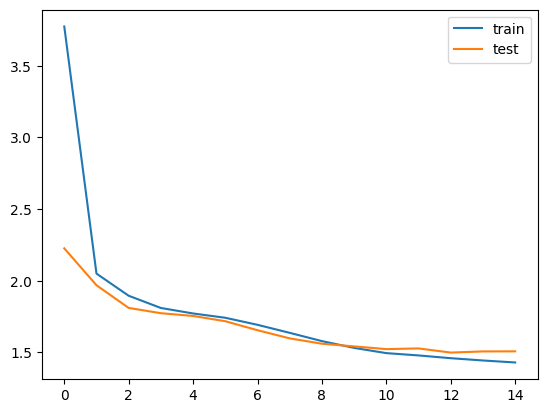

In [36]:
# Plot of Training and Validation loss
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [43]:
# Inference 
with open('reverse_target_word_index.pkl', 'rb') as file:
    # Call load method to deserialze
    reverse_target_word_index = pickle.load(file)
with open('reverse_source_word_index.pkl', 'rb') as file:
    # Call load method to deserialze
    reverse_source_word_index = pickle.load(file)
with open('target_word_index.pkl', 'rb') as file:
    # Call load method to deserialze
    target_word_index = pickle.load(file)
with open('encoder_model_custom_attention.pkl', 'rb') as file:
    # Call load method to deserialze
    encoder_model = pickle.load(file)

In [48]:
from tensorflow.keras.models import load_model
# Register the custom layer
tf.keras.utils.get_custom_objects()['AttentionLayer'] = AttentionLayer
# Load the saved decoder_model
decoder_model = load_model('decoder_model_custom_attention.h5')

In [49]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [50]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [54]:
x_tr[0].reshape(1,30)

array([[170, 642, 132,  41, 477, 196,   3, 542,   7,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

In [56]:
np.zeros((1,1))

array([[0.]])

In [57]:
target_word_index['sostok']

1

In [58]:
np.zeros((1,1))[0,0]

0.0

In [60]:
e_out, e_h, e_c = encoder_model.predict(x_tr[0].reshape(1,30))
e_out, e_h, e_c

1/1 [==============================] - 0s 72ms/step


(array([[[ 4.6994776e-04, -6.5058499e-04, -6.6889700e-04, ...,
          -1.2269472e-03,  1.6202088e-03, -1.9830300e-03],
         [-3.9875740e-03, -5.6383186e-03,  2.3605279e-04, ...,
          -2.3883339e-03, -1.5465015e-03,  1.6265975e-03],
         [-1.2086571e-02, -1.6272878e-02,  2.3299973e-03, ...,
          -4.8970408e-03, -1.0216282e-02,  1.2855504e-02],
         ...,
         [ 6.9929652e-02,  1.2640896e-01, -3.1063182e-02, ...,
           4.8828699e-02,  3.1777453e-01, -2.0859496e-01],
         [ 6.9548115e-02,  1.2602402e-01, -3.1039309e-02, ...,
           4.8507579e-02,  3.1805274e-01, -2.0769943e-01],
         [ 6.9289364e-02,  1.2571023e-01, -3.1011119e-02, ...,
           4.8260532e-02,  3.1826842e-01, -2.0706809e-01]]], dtype=float32),
 array([[ 6.92893639e-02,  1.25710234e-01, -3.10111195e-02,
         -6.94676042e-01, -1.26380935e-01,  4.99890894e-01,
         -1.35485023e-01, -4.33600605e-01, -5.26701689e-01,
          5.95116802e-02, -1.90837160e-02, -4.07756679e-

In [61]:
[np.zeros((1,1))[0,0]] + [e_out, e_h, e_c]

[0.0,
 array([[[ 4.6994776e-04, -6.5058499e-04, -6.6889700e-04, ...,
          -1.2269472e-03,  1.6202088e-03, -1.9830300e-03],
         [-3.9875740e-03, -5.6383186e-03,  2.3605279e-04, ...,
          -2.3883339e-03, -1.5465015e-03,  1.6265975e-03],
         [-1.2086571e-02, -1.6272878e-02,  2.3299973e-03, ...,
          -4.8970408e-03, -1.0216282e-02,  1.2855504e-02],
         ...,
         [ 6.9929652e-02,  1.2640896e-01, -3.1063182e-02, ...,
           4.8828699e-02,  3.1777453e-01, -2.0859496e-01],
         [ 6.9548115e-02,  1.2602402e-01, -3.1039309e-02, ...,
           4.8507579e-02,  3.1805274e-01, -2.0769943e-01],
         [ 6.9289364e-02,  1.2571023e-01, -3.1011119e-02, ...,
           4.8260532e-02,  3.1826842e-01, -2.0706809e-01]]], dtype=float32),
 array([[ 6.92893639e-02,  1.25710234e-01, -3.10111195e-02,
         -6.94676042e-01, -1.26380935e-01,  4.99890894e-01,
         -1.35485023e-01, -4.33600605e-01, -5.26701689e-01,
          5.95116802e-02, -1.90837160e-02, -4.0775

In [51]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: son allergies item loves convenience feel good giving taste great 
Original summary: my loves them 
1/1 [==============================] - 0s 50ms/step
Predicted summary:  great


Review: use like asian dishes least week love product fast shipping usual would buy 
Original summary: sauce 
1/1 [==============================] - 0s 49ms/step
Predicted summary:  great


Review: reason amazon would ship sent got enjoy good chips amazon shipping thing would order online 
Original summary: great chips 
1/1 [==============================] - 0s 44ms/step
Predicted summary:  great


Review: love chips delicious hard eat one bag flavors taste favorite flavor cheese ones go try delicious 
Original summary: pop delicious 
1/1 [==============================] - 0s 48ms/step
Predicted summary:  great


Review: expensive worth yet find marinade one add garlic vegetables choice mix sauce whatever meat choose two days believe get worth every 
Original summary: but it 
1/1 [====================